In [1]:
# default_exp data.tsloader_general

In [2]:
#hide
%load_ext autoreload
%autoreload 2

In [3]:
#export
import numpy as np
import pandas as pd
import random
import torch as t
import copy
from fastcore.foundation import patch
from nixtla.data.tsdataset import TimeSeriesDataset
from collections import defaultdict

In [4]:
#export
# TODO: train_masks no estan definidas para el DataloaderGeneral
# TODO: revisar _create_windows_tensor method para checar que la declaracion de la train_mask y su uso es correcto
#.      no sabemos si hay algo diferente respecto a su uso en el DataLoaderFast
# TODO: pensar variable shuffle para compatibilidad con dataloader de pytorch y keras
#.      por el momento tenemos solo validacion boostrapeada, no existe modo no shuffle
#.      para evaluacion no estocástica, nuestra validación está hackeada.
# TODO: _get_sampleable_windows_idxs linea muy malvada de windows con frequencia aumenta de 3.0 a 3.6 segundos el batch
# TODO thin about _is_train, is_train_loader interaction
class TimeSeriesLoader(object):
    def __init__(self,
                 ts_dataset: TimeSeriesDataset,
                 model: str,
                 offset: int,
                 window_sampling_limit: int, 
                 input_size: int,
                 output_size: int,
                 idx_to_sample_freq: int,
                 batch_size: int,
                 n_series_per_batch: int=None,
                 is_train_loader: bool,
                 shuffle: bool):
        """
        """
        # Dataloader attributes
        self.model = model
        self.window_sampling_limit = window_sampling_limit
        self.input_size = input_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.idx_to_sample_freq = idx_to_sample_freq
        self.offset = offset
        self.ts_dataset = ts_dataset
        self.t_cols = self.ts_dataset.t_cols
        self.is_train_loader = is_train_loader # Boolean variable for train and validation mask
        if n_series_per_batch is not None:
            self.n_series_per_batch = n_series_per_batch 
        else:
            self.n_series_per_batch = min(batch_size, self.ts_dataset.n_series)
        self.windows_per_serie = self.batch_size // self.n_series_per_batch
        self._is_train = True        # TODO thin about _is_train, is_train_loader interaction <-------
        self.shuffle = shuffle

        # Dataloader protections
        assert self.batch_size % self.n_series_per_batch == 0, \
                        f'batch_size {self.batch_size} must be multiple of n_series_per_batch {self.n_series_per_batch}'
        assert self.n_series_per_batch <= self.ts_dataset.n_series, \
                        f'n_series_per_batch {n_series_per_batch} needs to be smaller than n_series {self.ts_dataset.n_series}'
        assert offset < self.ts_dataset.max_len, \
            f'Offset {offset} must be smaller than max_len {self.ts_dataset.max_len}'

    def _get_sampleable_windows_idxs(self, ts_windows_flatten):
        # Only sample during training windows with at least one active output mask
        sampling_idx = t.sum(ts_windows_flatten[:, self.t_cols.index('outsample_mask'), -self.output_size:], axis=1)
        sampling_idx = t.nonzero(sampling_idx > 0)
        sampling_idx = list(sampling_idx.flatten().numpy())
        # TODO: pensar como resolver el hack de +1, 
        #.      el +1 está diseñado para addressear el shift que tenemos que garantiza que el primer train tenga
        #.      por lo menos un input en la train_mask, además este código necesita la condición de que la serie más larga empieza
        #.      en el ds del que se va a querer samplear con la frecuencia particular. Hay dos hacks ENORMES.
        sampling_idx = [idx for idx in sampling_idx if (idx+1) % self.idx_to_sample_freq==0] # TODO: Esta linea muy malvada aumenta .6 segundos
        return sampling_idx        

    def _create_windows_tensor(self, ts_idxs=None):
        """
        Comment here
        TODO: Cuando creemos el otro dataloader, si es compatible lo hacemos funcion transform en utils
        """
        # Filter function is used to define train tensor and validation tensor with the offset
        # Default ts_idxs=ts_idxs sends all the data, otherwise filters series      
        tensor, right_padding, train_mask = self.ts_dataset.get_filtered_ts_tensor(offset=self.offset, output_size=self.output_size,
                                                                                   window_sampling_limit=self.window_sampling_limit,
                                                                                   ts_idxs=ts_idxs)
        tensor = t.Tensor(tensor)

        # Outsample mask checks existance of values in ts, train_mask mask is used to filter out validation
        # is_train_loader inverts the train_mask in case the dataloader is in validation mode
        mask = train_mask if self.is_train_loader else (1 - train_mask)
        tensor[:, self.t_cols.index('outsample_mask'), :] = tensor[:, self.t_cols.index('outsample_mask'), :] * mask

        padder = t.nn.ConstantPad1d(padding=(self.input_size-1, right_padding), value=0)
        tensor = padder(tensor)

        # Last output_size outsample_mask and y to 0
        tensor[:, self.t_cols.index('y'), -self.output_size:] = 0 # overkill to ensure no validation leakage
        tensor[:, self.t_cols.index('outsample_mask'), -self.output_size:] = 0

        # Creating rolling windows and 'flattens' them
        windows = tensor.unfold(dimension=-1, size=self.input_size + self.output_size, step=1)
        windows = windows.permute(2,0,1,3)
        windows = windows.reshape(-1, self.ts_dataset.n_channels, self.input_size + self.output_size)
        return windows

    def __iter__(self):
        n_series = self.ts_dataset.n_series
        # Shuffle idx before epoch if self._is_train
        if self.shuffle:
            sample_idxs = np.random.choice(a=range(n_series), size=n_series, replace=False)
        else:
            sample_idxs = np.array(range(n_series))
        
        n_batches = int(np.ceil(n_series / self.n_series_per_batch)) # Must be multiple of batch_size for paralel gpu

        for idx in range(n_batches):
            ts_idxs = sample_idxs[(idx * self.n_series_per_batch) : (idx + 1) * self.n_series_per_batch]
            batch = self.__get_item__(index=ts_idxs)
            yield batch

    def __get_item__(self, index):
        if (self.model == 'nbeats') or (self.model == 'tcn'):
            return self._windows_batch(index)
        elif self.model == 'esrnn':
            return self._full_series_batch(index)
        else:
            assert 1<0, 'error'

    def _windows_batch(self, index):

        # Create windows for each sampled ts and sample random unmasked windows from each ts
        windows = self._create_windows_tensor(ts_idxs=index)
    
        if self._is_train:
            sampleable_windows = self._get_sampleable_windows_idxs(ts_windows_flatten=windows)
            windows_idxs = np.random.choice(sampleable_windows, self.batch_size, replace=True)
            windows = windows[windows_idxs]
        else:
            windows_idxs = index
            windows = windows[-len(index):]
        
        #TODO: Fix this part. We have not tested the addition of static variables in DataLoaderGeneral
        #.     This is inspired in the repeat of the in DataLoaderFast
        s_matrix = self.ts_dataset.s_matrix[index]
        s_matrix = s_matrix.repeat(self.windows_per_serie, 1)
        s_matrix = s_matrix[windows_idxs]

        insample_y = windows[:, self.t_cols.index('y'), :self.input_size]
        insample_x = windows[:, (self.t_cols.index('y')+1):self.t_cols.index('insample_mask'), :self.input_size]
        insample_mask = windows[:, self.t_cols.index('insample_mask'), :self.input_size]

        outsample_y = windows[:, self.t_cols.index('y'), self.input_size:]
        outsample_x = windows[:, (self.t_cols.index('y')+1):self.t_cols.index('insample_mask'), self.input_size:]
        outsample_mask = windows[:, self.t_cols.index('outsample_mask'), self.input_size:]

        batch = {'s_matrix': s_matrix,
                 'insample_y': insample_y, 'insample_x':insample_x, 'insample_mask':insample_mask,
                 'outsample_y': outsample_y, 'outsample_x':outsample_x, 'outsample_mask':outsample_mask}
        return batch

    def _full_series_batch(self, index):
        #TODO: meter get filter tensor
        ts_tensor, _, _ = self.ts_dataset.get_filtered_ts_tensor(offset=self.offset, output_size=self.output_size,
                                                                 window_sampling_limit=self.window_sampling_limit,
                                                                 ts_idxs=index)
        # Trim batch to shorter time series to avoid zero padding
        insample_y = ts_tensor[:, self.t_cols.index('y'), :]
        batch_len_series = np.array(self.ts_dataset.len_series)[index]
        min_batch_len = np.min(batch_len_series)
        insample_y = insample_y[:, -min_batch_len:]

        insample_x = ts_tensor[:, self.t_cols.index('y')+1:self.t_cols.index('insample_mask'), :]
        insample_x = insample_x[:, -min_batch_len:]

        s_matrix = self.ts_dataset.s_matrix[index]

        batch = {'insample_y': insample_y, 'idxs': index, 'insample_x': insample_x, 's_matrix': s_matrix}

        return batch

    def update_offset(self, offset):
        if offset == self.offset:
            return # Avoid extra computation
        self.offset = offset

    def get_meta_data_col(self, col):
        return self.ts_dataset.get_meta_data_col(col)

    def get_n_variables(self):
        return self.ts_dataset.n_x, self.ts_dataset.n_s

    def get_n_series(self):
        return self.ts_dataset.n_series

    def get_max_len(self):
        return self.ts_dataset.max_len

    def get_n_channels(self):
        return self.ts_dataset.n_channels

    def get_X_cols(self):
        return self.ts_dataset.X_cols

    def get_frequency(self):
        return self.ts_dataset.frequency

    def train(self):
        self._is_train = True

    def eval(self):
        self._is_train = False

In [5]:
import matplotlib.pyplot as plt
from nixtla.data.datasets.m4 import M4, M4Info
m4_dataset = M4.load(directory='../data', group=M4Info.groups[0])

Processing dataframes ...
Creating ts tensor ...


In [6]:
ts_loader = TimeSeriesLoader(ts_dataset=m4_dataset,
                             model='nbeats',
                             offset=0,
                             window_sampling_limit=50, 
                             input_size=30,
                             output_size=6,
                             idx_to_sample_freq=1,
                             batch_size=1024,
                             is_train_loader=True,
                             shuffle=True)

# For shuffle bool testing purpose
ts_tensor, _, _ = m4_dataset.get_filtered_ts_tensor(offset=0, output_size=6,
                                                    window_sampling_limit=50,
                                                    ts_idxs=0)

In [7]:
dataloader = iter(ts_loader)
batch = next(dataloader)
insample_y = batch['insample_y']
insample_x_t = batch['insample_x']
insample_mask = batch['insample_mask']
outsample_y = batch['outsample_y']
outsample_x = batch['outsample_x']
outsample_mask = batch['outsample_mask']

print("m4_dataset.t_cols", m4_dataset.t_cols)
print("ts_loader.input_size", ts_loader.input_size)
print("ts_loader.output_size", ts_loader.output_size)
print("insample_y.shape", insample_y.shape)
print("outsample_y.shape", outsample_y.shape)
print("ts_tensor.shape", ts_tensor.shape)

m4_dataset.t_cols ['y', 'insample_mask', 'outsample_mask']
ts_loader.input_size 30
ts_loader.output_size 6
insample_y.shape torch.Size([1024, 30])
outsample_y.shape torch.Size([1024, 6])
ts_tensor.shape (3, 50)


In [8]:
#insample_y

In [9]:
#outsample_y

In [10]:
#insample_mask.shape

In [11]:
#outsample_mask.mean()

Checking order for unshuffled validation


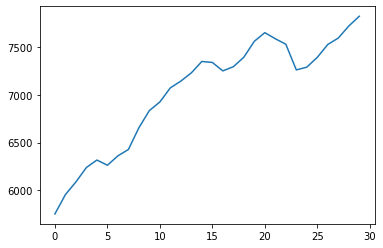

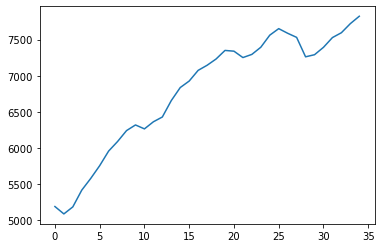

In [12]:
ts_loader._is_train = False
ts_loader.shuffle = False
dataloader = iter(ts_loader)
batch = next(dataloader)
insample_y = batch['insample_y']

print("Checking order for unshuffled validation")
plt.plot(insample_y[0,:])
plt.show()

plt.plot(ts_tensor[0,15:])
plt.show()